In [10]:
# ------------------------- Import Libraries and Load Data ------------------------

# Import necessary libraries
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('aggregated_fantasy_data.csv')

# Display the first few rows to understand the structure of the data
print(df.head())

          Player  Rushing Yards  Receiving Yards  Passing Yards  Total TD  \
0     A.J. Brown           70.0             4491            0.0      21.0   
1     A.J. Green            0.0             1371            0.0       2.0   
2      AJ Dillon          803.0              519            0.0       0.0   
3    Aaron Jones         2987.0             1615            0.0      30.0   
4  Aaron Rodgers          433.0              -10         7994.0       4.0   

   Fantasy Points  Games Played Position  Yards_from_Scrimmage  Total_Yards  \
0             673            60       WR                4561.0       4561.0   
1             167            32       WR                1371.0       1371.0   
2             292            34       RB                1322.0       1322.0   
3             845            62       RB                4602.0       4602.0   
4            1231            65       QB                 423.0       8417.0   

     Avg_TD  Avg_Yards_from_Scrimmage  Avg_Passing_Yards  Avg_

In [2]:
# ----------------------------- Data Preparation -----------------------------

# Feature Engineering: Creating new features for Total Yards and Yards from Scrimmage
df['Total_Yards'] = df['Rushing Yards'] + df['Receiving Yards'] + df['Passing Yards']
df['Yards_from_Scrimmage'] = df['Rushing Yards'] + df['Receiving Yards']

# Create average metrics per game
df['Avg_Rushing_Yards'] = df['Rushing Yards'] / df['Games Played']
df['Avg_Receiving_Yards'] = df['Receiving Yards'] / df['Games Played']
df['Avg_Passing_Yards'] = df['Passing Yards'] / df['Games Played']
df['Avg_TD'] = df['Total TD'] / df['Games Played']
df['Avg_Yards_from_Scrimmage'] = df['Yards_from_Scrimmage'] / df['Games Played']

# Handle Missing Values using SimpleImputer (mean strategy for numeric columns)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Encoding categorical data (Position)
df_encoded = pd.get_dummies(df, columns=['Position'], drop_first=True)

# Display the first few rows after encoding
print(df_encoded.head())

          Player  Rushing Yards  Receiving Yards  Passing Yards  Total TD  \
0     A.J. Brown           70.0           4491.0            0.0      21.0   
1     A.J. Green            0.0           1371.0            0.0       2.0   
2      AJ Dillon          803.0            519.0            0.0       0.0   
3    Aaron Jones         2987.0           1615.0            0.0      30.0   
4  Aaron Rodgers          433.0            -10.0         7994.0       4.0   

   Fantasy Points  Games Played  Yards_from_Scrimmage  Total_Yards    Avg_TD  \
0           673.0          60.0                4561.0       4561.0  0.350000   
1           167.0          32.0                1371.0       1371.0  0.062500   
2           292.0          34.0                1322.0       1322.0  0.000000   
3           845.0          62.0                4602.0       4602.0  0.483871   
4          1231.0          65.0                 423.0       8417.0  0.061538   

   Avg_Yards_from_Scrimmage  Avg_Passing_Yards  Avg_Tota

In [3]:
# ---------------------------- Data Splitting ------------------------------
# Here, we split the dataset into features and target variables, followed by creating the training, validation, and test splits.

# Split the dataset into features (X) and target (y)
X = df_encoded.drop(columns=['Player', 'Fantasy Points'])  # Dropping 'Player' and 'Fantasy Points' columns
y = df_encoded['Fantasy Points']  # Target variable (Fantasy Points)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (252, 17)
Validation data shape: (54, 17)
Test data shape: (54, 17)


In [4]:
# ------------------------- Model Building -----------------------------
# This section focuses on training the XGBoost model using the prepared data.

# Initialize XGBoost model
model = XGBRegressor()

# Train the model on the training data
model.fit(X_train, y_train)

# Display model's training performance
print(f"Model trained with parameters: {model.get_params()}")

Model trained with parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


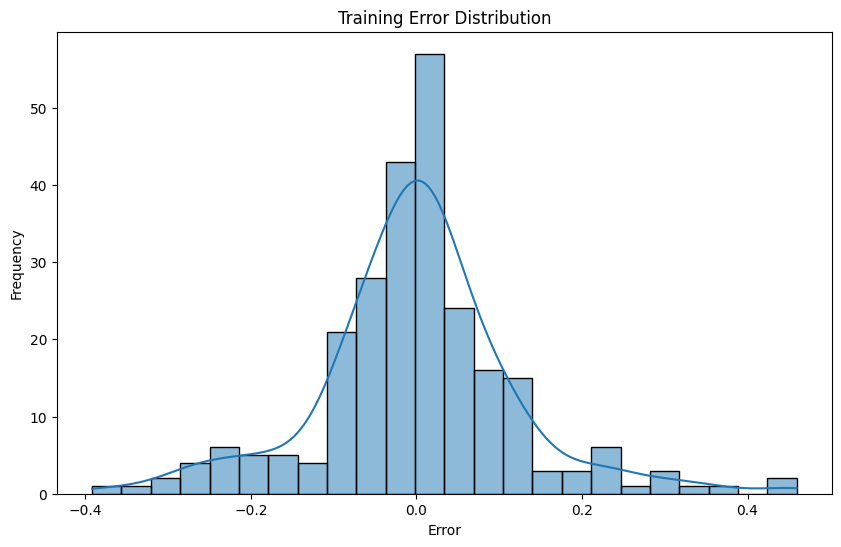

Training RMSE: 0.12036302922093382
Validation RMSE: 70.58586895524883
Test RMSE: 50.297517474045584
Cross-validation RMSE: 78.35450767848394


In [5]:
# ------------------------- Model Evaluation ----------------------------
# In this section, I evaluate the model's performance using RMSE (Root Mean Squared Error) on
# training, validation, and test datasets. Cross-validation is also performed for consistency.


# Model Error Analysis - Analyze residuals on training data
y_train_pred = model.predict(X_train)
train_errors = y_train - y_train_pred

# Plotting the error distribution for the training dataset
plt.figure(figsize=(10,6))
sns.histplot(train_errors, kde=True)
plt.title('Training Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Evaluate model performance on training, validation, and test datasets
train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
val_rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))
test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

# Print RMSE for all datasets
print(f"Training RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")

# Cross-validation to check performance (using training data)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross-validation RMSE: {-cv_scores.mean()}")

<Figure size 1000x800 with 0 Axes>

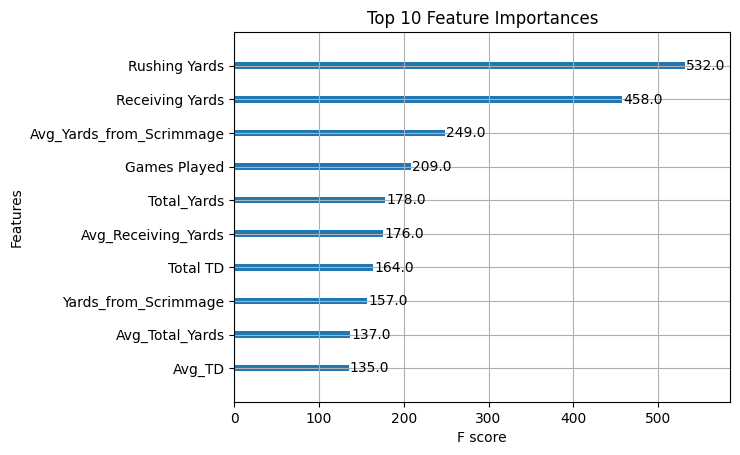

Top 10 Important Features:
                     Feature  Importance
0              Rushing Yards       532.0
1            Receiving Yards       458.0
8   Avg_Yards_from_Scrimmage       249.0
4               Games Played       209.0
6                Total_Yards       178.0
12       Avg_Receiving_Yards       176.0
3                   Total TD       164.0
5       Yards_from_Scrimmage       157.0
10           Avg_Total_Yards       137.0
7                     Avg_TD       135.0


In [6]:
# --------------------------- Feature Importance ---------------------------
# This section analyzes the importance of each feature used by the model in making predictions.

# Plot feature importance directly using XGBoost's built-in function
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight', max_num_features=10, title="Top 10 Feature Importances")
plt.show()

# Extract feature importance as a DataFrame
feature_importances = model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

print("Top 10 Important Features:")
print(importance_df.head(10))

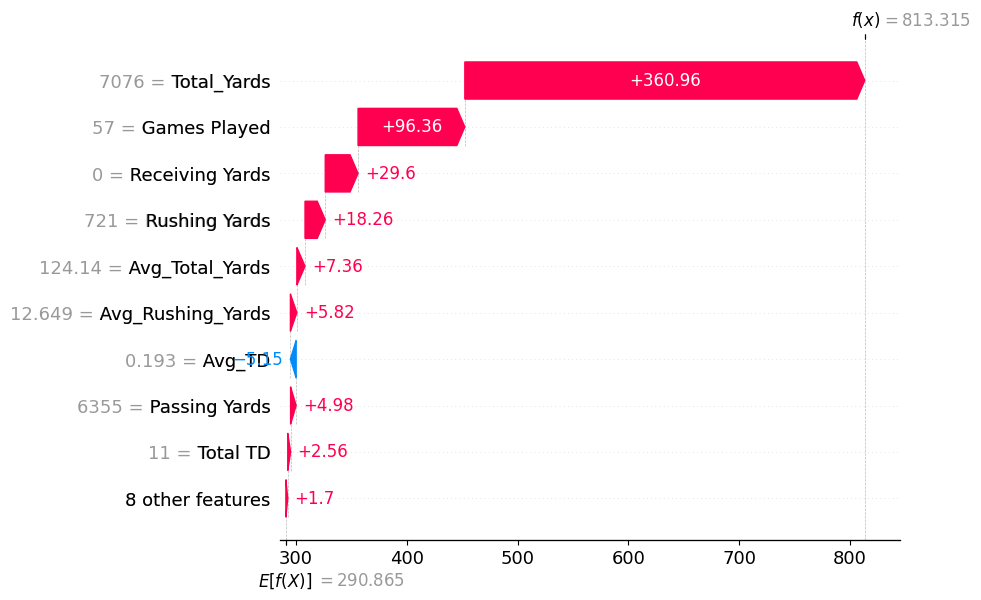

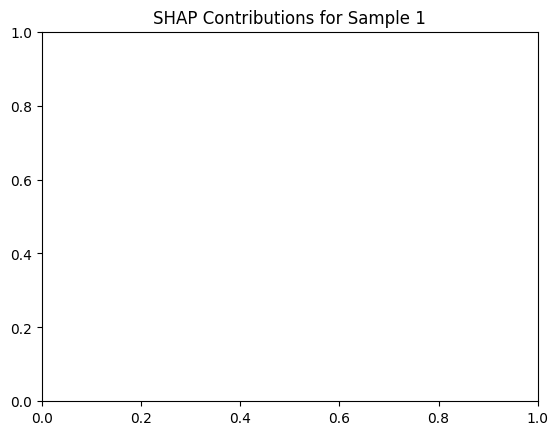

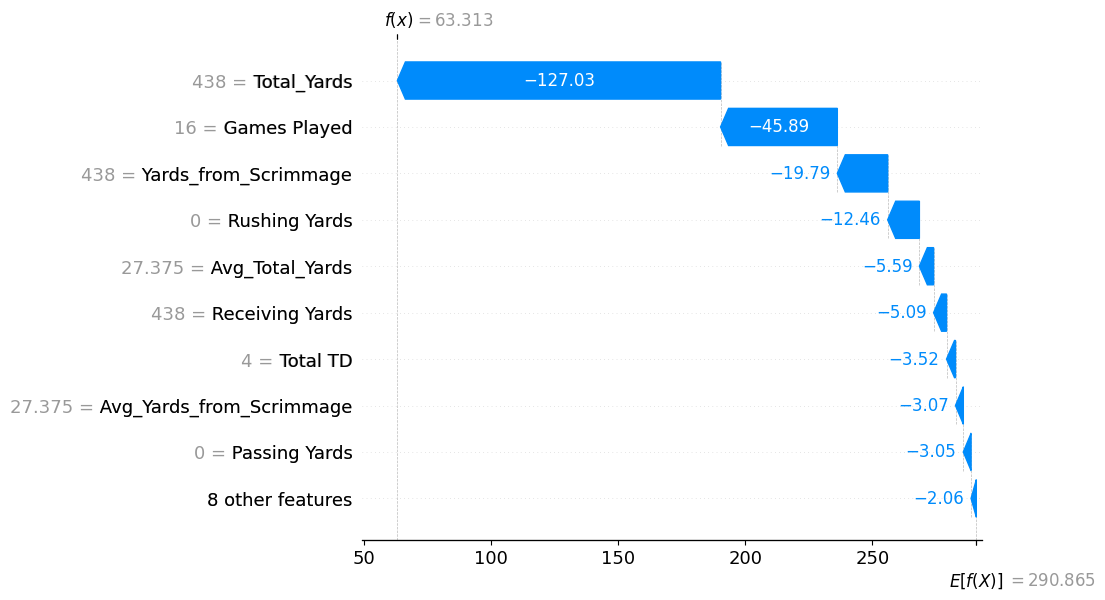

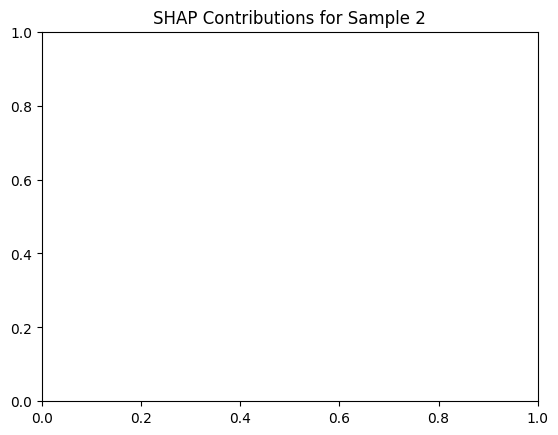

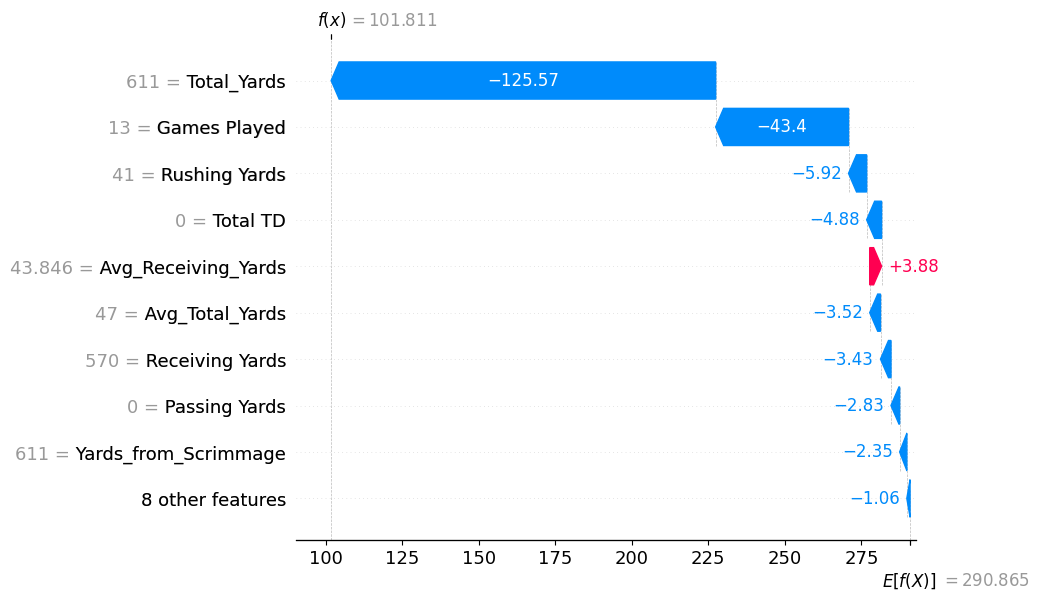

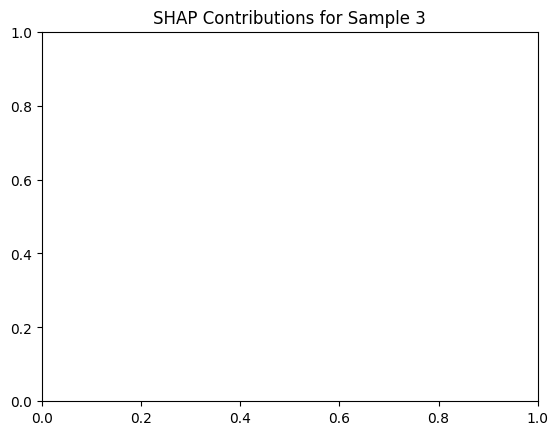

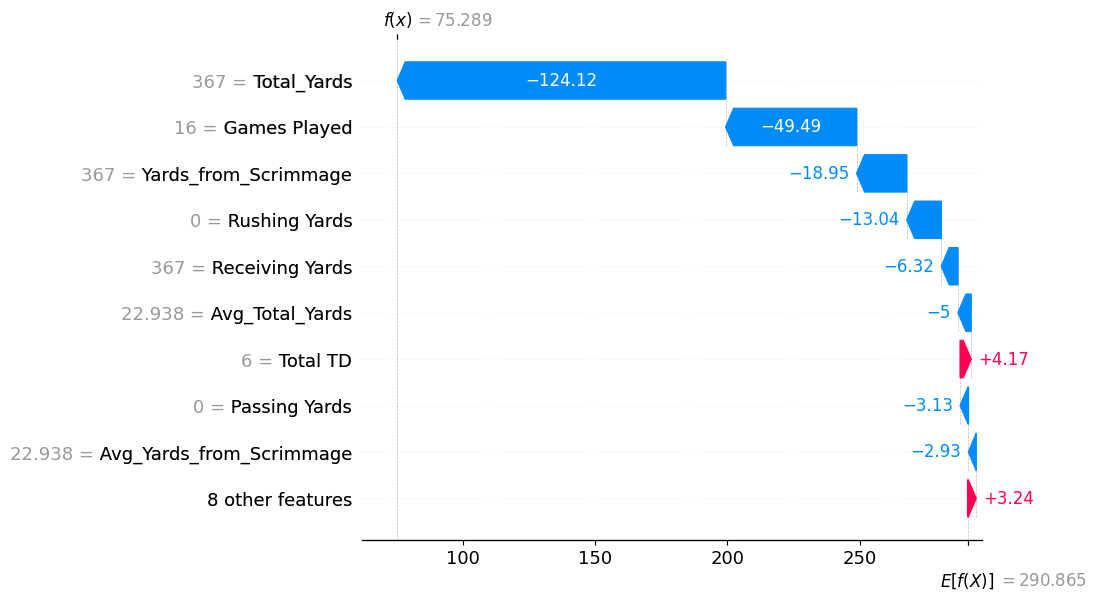

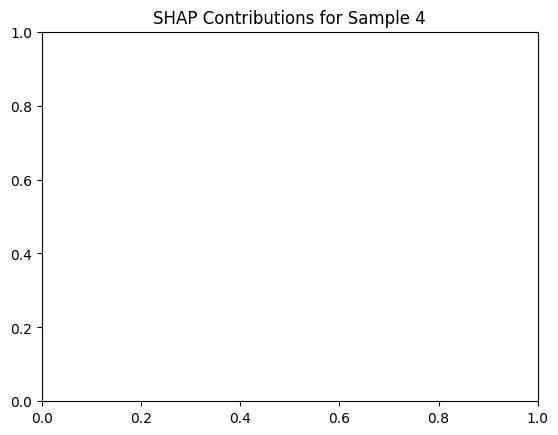

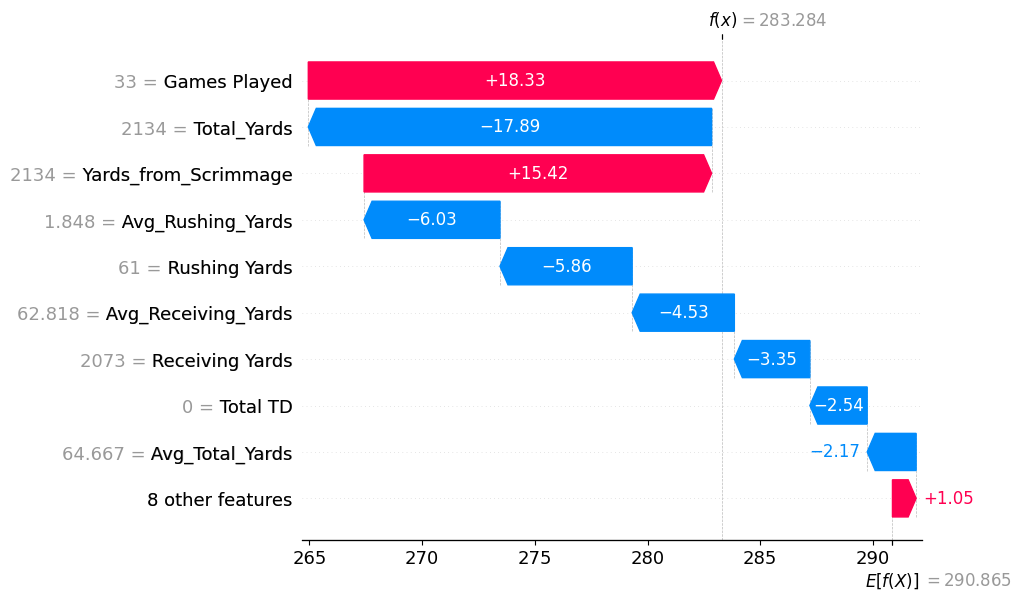

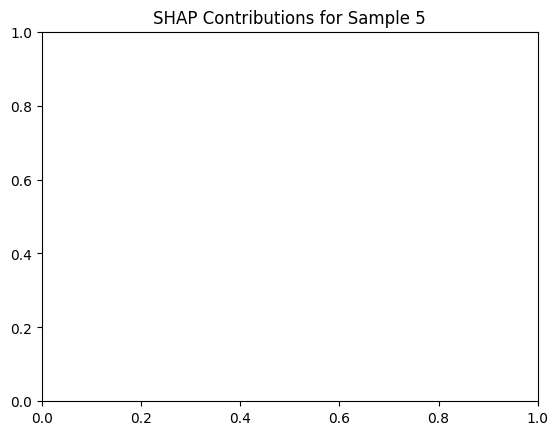

In [7]:
# --------------------------- SHAP Analysis ----------------------------
# Here, SHAP (SHapley Additive exPlanations) is used to explain the predictions of the model for a few selected samples.


# Convert position values to float for SHAP
X_train = X_train.astype(float)

# Create SHAP explainer for the XGBoost model
explainer = shap.Explainer(model, X_train)

# Randomly select 5 rows from the test set
random_samples = X_test.sample(5, random_state=42)
predictions = model.predict(random_samples)

# Analyze each prediction with SHAP
for idx, input_row in enumerate(X_test.sample(5, random_state=42).iterrows()):
    input_features = input_row[1].to_frame().T  # Convert to DataFrame with one row
    shap_values = explainer(input_features)
    
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values.values[0],
            base_values=shap_values.base_values[0],
            data=input_features.values[0],
            feature_names=input_features.columns
        )
    )
    plt.title(f"SHAP Contributions for Sample {idx+1}")
    plt.show()


Correlation of Games Played with target: 0.797189395314066


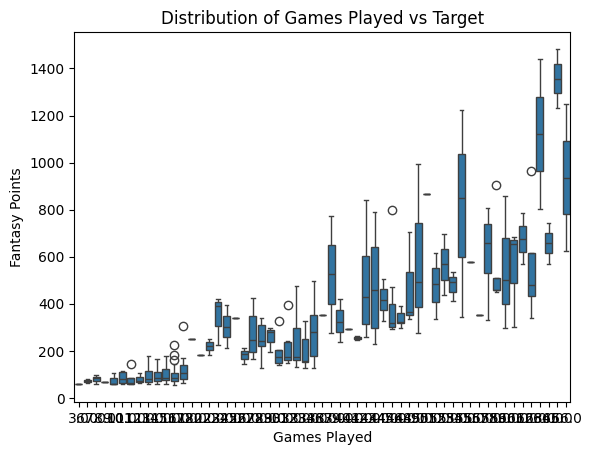

Adjusted Training RMSE: 0.16387210111829767
Adjusted Validation RMSE: 73.5157605785658
Adjusted Test RMSE: 51.892565489237626


In [8]:
# --------------------------- Bias Detection ----------------------------
# In this chunk, I check for potential biases in protected features and then mitigate them by adjusting the dataset or the model.


# Check for potential bias in protected features
protected_columns = ['Games Played']
for col in protected_columns:
    if col in X_train.columns:
        correlation = X_train[col].corr(y_train)
        print(f"Correlation of {col} with target: {correlation}")
        
        # Optional visualization
        if 'Position' in col:
            sns.barplot(data=X_train, x=col, y=y_train)
            plt.title(f"Distribution of {col} vs Target")
        else:
            sns.boxplot(data=X_train, x=col, y=y_train)
            plt.title(f"Distribution of {col} vs Target")
        plt.show()

# ---------------------------- Bias Mitigation ---------------------------

# Remove protected category features (if included in the dataset)
X_train_adj = X_train.drop(columns=protected_columns, errors='ignore')
X_val_adj = X_val.drop(columns=protected_columns, errors='ignore')
X_test_adj = X_test.drop(columns=protected_columns, errors='ignore')

# Retrain the model on adjusted training data
model_refit = XGBRegressor(**model.get_params())  # Copy parameters from the original model
model_refit.fit(X_train_adj, y_train)

# Evaluate metrics on adjusted data
train_rmse_adj = np.sqrt(mean_squared_error(y_train, model_refit.predict(X_train_adj)))
val_rmse_adj = np.sqrt(mean_squared_error(y_val, model_refit.predict(X_val_adj)))
test_rmse_adj = np.sqrt(mean_squared_error(y_test, model_refit.predict(X_test_adj)))

print(f"Adjusted Training RMSE: {train_rmse_adj}")
print(f"Adjusted Validation RMSE: {val_rmse_adj}")
print(f"Adjusted Test RMSE: {test_rmse_adj}")


In [27]:
# ---------------------------- Deployment and Prediction ----------------------------
# In this final chunk, I make predictions on random test samples and summarize the model's performance.

# Randomly select 5 samples from the test set
random_indices = random.sample(range(X_test.shape[0]), 5)
selected_samples = X_test.iloc[random_indices]
selected_true_values = y_test.iloc[random_indices]

# Check if 'Games Played' exists in the columns before trying to drop it
if 'Games Played' in X_test.columns:
    X_test = X_test.drop(columns=['Games Played'], axis=1)

# Ensure that the columns in the test set match the ones used during training
X_test = X_test[['Rushing Yards', 'Receiving Yards', 'Passing Yards', 'Total TD', 'Yards_from_Scrimmage',
                 'Total_Yards', 'Avg_TD', 'Avg_Yards_from_Scrimmage', 'Avg_Passing_Yards', 'Avg_Total_Yards',
                 'Avg_Rushing_Yards', 'Avg_Receiving_Yards', 'Position_QB', 'Position_RB', 'Position_TE', 'Position_WR']]

# Predict the fantasy football points for the selected samples using the refitted model
selected_predictions = model_refit.predict(selected_samples)

# Display predictions and true values
print("Selected Predictions and True Values:")
for i, idx in enumerate(random_indices):
    print(f"Sample {idx}: Predicted: {selected_predictions[i]}, True Value: {selected_true_values.iloc[i]}")

Selected Predictions and True Values:
Sample 25: Predicted: 129.11859130859375, True Value: 72.0
Sample 21: Predicted: 816.1009521484375, True Value: 868.0
Sample 15: Predicted: 734.6453857421875, True Value: 830.0
Sample 28: Predicted: 71.35350799560547, True Value: 65.0
Sample 35: Predicted: 113.43902587890625, True Value: 115.0
